In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
import tensorflow.keras.backend as K

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import h5py

seed = 56

In [0]:
IMAGE_HEIGHT = IMAGE_WIDTH = 608
NUM_CHANNELS = 3
image_file = '/content/gdrive/My Drive/Road_Segmentation/training/train_images.h5py'
mask_file = '/content/gdrive/My Drive/Road_Segmentation/training/train_masks.h5py'

actual_images_path = '/content/gdrive/My Drive/Road_Segmentation/actual_test_images.h5py'

In [27]:
hfile = h5py.File(image_file, 'r')
n1 = hfile.get('all_images')
images = np.array(n1)
print(images.shape)
hfile.close()

(600, 608, 608, 3)


In [28]:
hfile = h5py.File(mask_file, 'r')
n1 = hfile.get('all_masks')
masks = np.array(n1)
print(masks.shape)
print("Unique elements in the train mask:", np.unique(masks))
hfile.close()

(600, 608, 608)
Unique elements in the train mask: [  0 255]


In [29]:
#ACTUAL TESTING IMAGES
hfile = h5py.File(actual_images_path, 'r')
n1 = hfile.get('all_test_images')
actual_test_images = np.array(n1)
print(actual_test_images.shape)
hfile.close()

(50, 608, 608, 3)


In [0]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

In [0]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [0]:
masks = np.expand_dims(masks, -1)


In [33]:
print(masks.shape)
print(images.shape)


(600, 608, 608, 1)
(600, 608, 608, 3)


In [34]:
# from sklearn.model_selection import train_test_split
# train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=seed)
# del images, masks
# print("TRAIN SET")
# print(train_images.shape)
# print(train_masks.shape)
# print("TEST SET")
# print(test_images.shape)
# print(test_masks.shape)

train_images = images
train_masks = masks
print(train_images.shape)
print(train_masks.shape)

(600, 608, 608, 3)
(600, 608, 608, 1)


In [0]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
import keras

In [36]:
inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 608, 608, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 608, 608, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 608, 608, 16) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [0]:
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

In [0]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

In [39]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://34bd05c3.ngrok.io


In [0]:

model_path = "/content/gdrive/My Drive/Road_Segmentation/training/Models/road_mapper_2.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 30,
                          verbose = 1,
                          restore_best_weights = True)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=10,
                               verbose=1,
                               epsilon=1e-4)

In [0]:
opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])

In [42]:
history = model.fit(train_images,
                    train_masks/255,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                       )

Train on 540 samples, validate on 60 samples


Epoch 1/100
540/540 [==============================] - 31s 57ms/step - loss: 0.6747 - iou_coef: 0.1923 - val_loss: 0.6012 - val_iou_coef: 0.2483

Epoch 00001: val_loss improved from inf to 0.60122, saving model to /content/gdrive/My Drive/Road_Segmentation/training/Models/road_mapper_2.h5

Epoch 2/100
540/540 [==============================] - 23s 43ms/step - loss: 0.5557 - iou_coef: 0.2849 - val_loss: 0.4405 - val_iou_coef: 0.3738

Epoch 00002: val_loss improved from 0.60122 to 0.44050, saving model to /content/gdrive/My Drive/Road_Segmentation/training/Models/road_mapper_2.h5
Epoch 3/100
540/540 [==============================] - 23s 43ms/step - loss: 0.4610 - iou_coef: 0.3683 - val_loss: 0.4600 - val_iou_coef: 0.3575

Epoch 00003: val_loss did not improve from 0.44050
Epoch 4/100
540/540 [==============================] - 23s 43ms/step - loss: 0.4083 - iou_coef: 0.4178 - val_loss: 0.3508 - val_iou_coef: 0.4445

Epoch 00004: val_loss imp

In [0]:
model.save("/content/gdrive/My Drive/Road_Segmentation/training/Models/road_mapper_final.h5")

In [0]:
#TESTING MODEL with TEST IMAGES

In [0]:
model = load_model("/content/gdrive/My Drive/Road_Segmentation/training/Models/road_mapper_final.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})

In [16]:
model.evaluate(test_images, test_masks)

120/120 [==============================] - 10s 86ms/step


[-0.5078314701716106, 6.076172415415446]

In [17]:
predictions = model.predict(test_images, verbose=1)

120/120 [==============================] - 2s 19ms/step


In [18]:
print("Predictions made by model: ")
print(predictions.shape)
print("test_masks groundtruth: ")
print(test_masks.shape)

Predictions made by model: 
(120, 608, 608, 1)
test_masks groundtruth: 
(120, 608, 608, 1)


In [0]:
thresh_val = 0.25
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

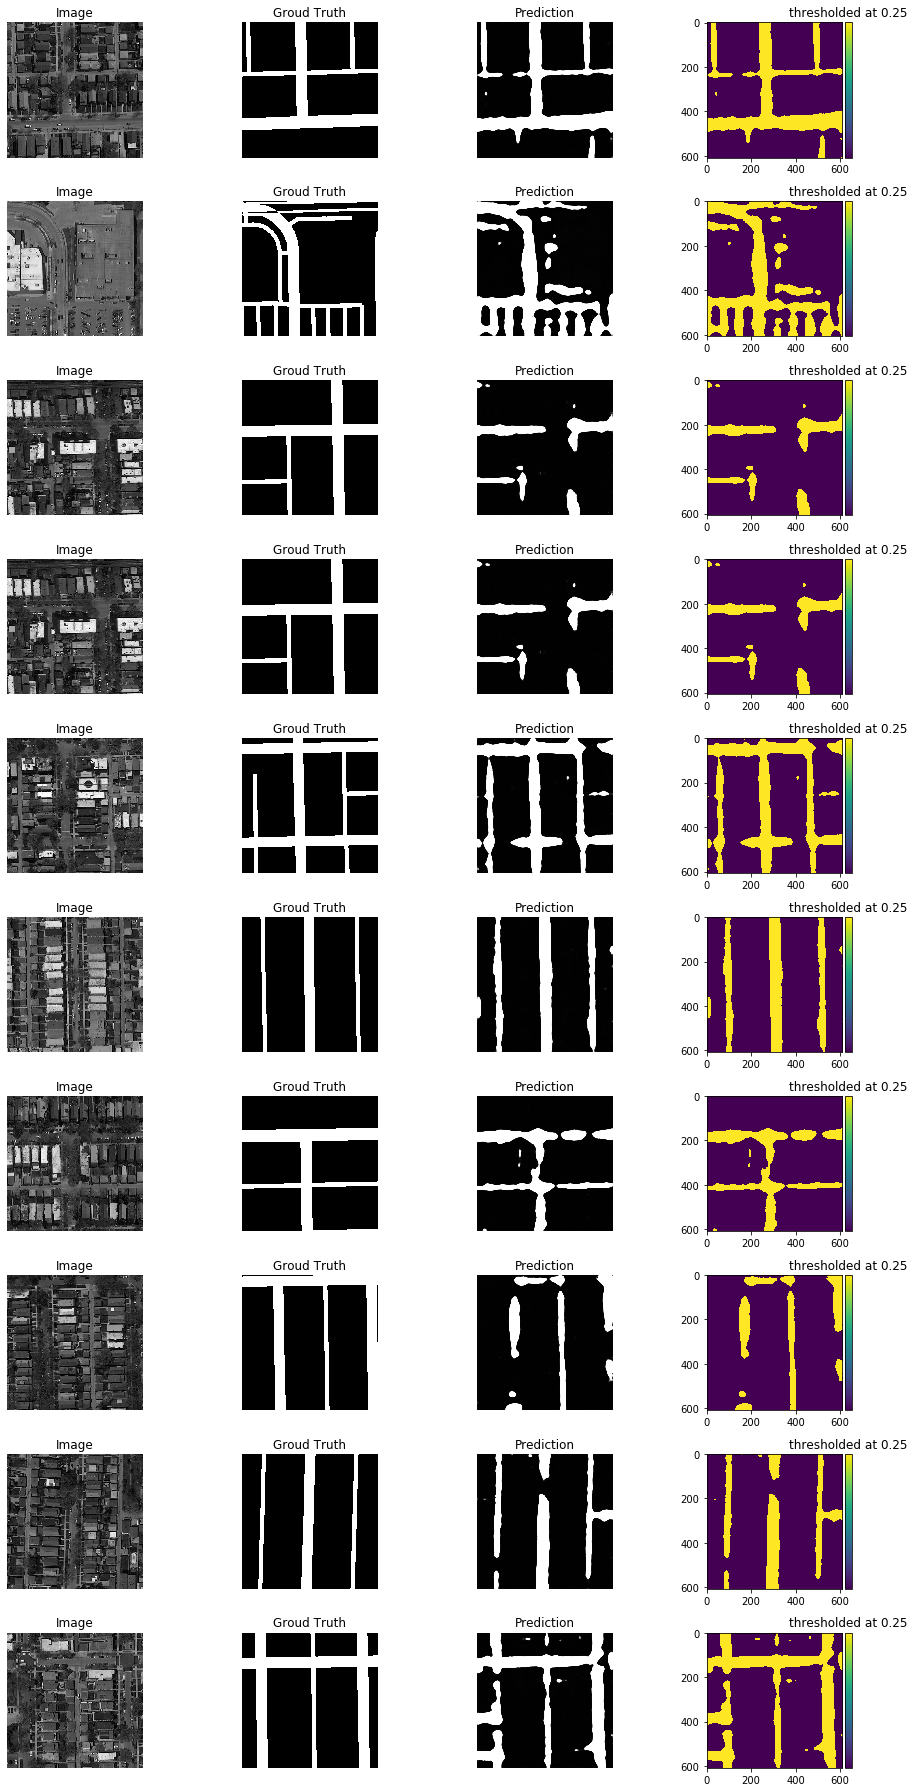

In [20]:
ix = random.randint(0, len(predictions))
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  ix = random.randint(0, len(predictions))

  f.add_subplot(num_samples, 4, i)
  imshow(test_images[ix][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  imshow(np.squeeze(test_masks[ix][:,:,0]))
  plt.title("Groud Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  imshow(np.squeeze(predictions[ix][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+3)
  imshow(np.squeeze(predicton_threshold[ix][:,:,0]))
  plt.title("thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()

In [21]:
y_flatten = predictions.flatten()
for i in range(len(y_flatten)):
  # print(y_flatten[i])
  if(y_flatten[i]>0.25):
    y_flatten[i] = int(255)
  else:  
    y_flatten[i] = int(0)
print(min(y_flatten))
print(max(y_flatten))
# y_flatten = int(y_flatten)
# print(type(y_flatten))
y_flatten = np.asarray(y_flatten)

0.0
255.0


In [22]:
print(type(test_masks))
print(type(predictions))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [23]:
import numpy as np
print("Unique values of test_masks")
print(np.unique(test_masks))
print("Unique values of predictions before thresholding")
print(np.unique(predictions))

Unique values of test_masks
[  0 255]
Unique values of predictions before thresholding
[0.0000000e+00 2.9802322e-08 5.9604645e-08 ... 9.9999642e-01 9.9999666e-01
 9.9999678e-01]


In [24]:
from sklearn.metrics import classification_report
from keras.backend import flatten as kerasflatten

# new_test_masks = []
# new_predictions = []

# for i in range(20):

# #   ret,thresh1 = cv2.threshold(test_masks[i],64,255,cv2.THRESH_BINARY)
# #   new_test_masks.append(thresh1)
#   ret,thresh2 = cv2.threshold(predictions[i],64,255,cv2.THRESH_BINARY)
#   new_predictions.append(thresh2)

# new_test_masks = np.asarray(new_test_masks)
# new_predictions = np.asarray(new_predictions)


print(classification_report(y_test, y_flatten))



NameError: ignored

In [0]:
new_predictions[5][:,:,0]f = plt.figure(figsize = (15, 25))

IndexError: ignored

In [0]:
print(predictions.shape)

(20, 400, 400, 1)


In [0]:
#RUNNING THE MODEL IN TEST SET 

In [46]:
predictions = model.predict(actual_test_images, verbose=1)

50/50 [==============================] - 3s 57ms/step


In [47]:
print(predictions.shape)
print(actual_test_images.shape)

(50, 608, 608, 1)
(50, 608, 608, 3)


In [48]:
np.unique(predictions)

array([0.0000000e+00, 2.9802322e-08, 5.9604645e-08, ..., 9.9996948e-01,
       9.9996984e-01, 9.9997360e-01], dtype=float32)

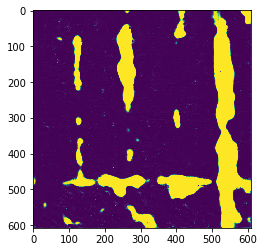

In [59]:
plt.imshow(predictions[0][:,:,0])

In [0]:
submission_predictions = []
#CONVERTING 400 to 608
for i in range(predictions.shape[0]):
  print(predictions[i].shape)
  m =  cv2.resize(predictions[i], (608,608), interpolation = cv2.INTER_AREA)
  m = m.reshape(608,608,1)
  # print(m.shape)
  # break
  submission_predictions.append(m)

  # print(predictions[i].shape)
submission_predictions = np.asarray(submission_predictions)  
print(submission_predictions.shape)

(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(400, 400, 1)
(50, 608, 608, 1)


In [0]:
# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

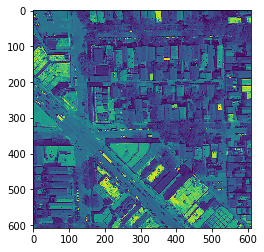

In [69]:
i = 5
plt.imshow(actual_test_images[i][:,:,0])


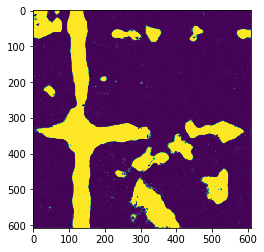

In [70]:
plt.imshow(predictions[i][:,:,0])

In [0]:
#WRITING IMAGES GENERATED BY THE MODEL : 

In [0]:
predictions.shape

(50, 400, 400, 1)

In [0]:
# os.chdir('/content/gdrive/My Drive/Road_Segmentation/Model_generated_images')


# for i in range(predictions.shape[0]):
#   y = i+1
#   nitin = np.moveaxis(predictions[i],-1,0)
#   filename = "generated_img_" + str(y)+ ".png" 
#   cv2.imwrite(str(filename), nitin[0])

In [0]:
# # in_image = np.moveaxis(in_image, -1, 0)
# nitin = np.moveaxis(predictions[0],-1,0)
# print(predictions[0].shape)
# # predictions[0] = np.moveaxis(predictions[0],-1,0)

# print(nitin[0].shape)

(400, 400, 1)
(400, 400)


In [0]:
import os
import numpy as np
import matplotlib.image as mpimg
import re

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename,fn):
    fn = fn + 1
    """Reads a single image and outputs the strings that should go into the submission file"""
    # img_number = int(re.search(r"\d+", image_filename).group(0))
    img_number = fn
    # im = mpimg.imread(image_filename)
    im = image_filename
    im = np.moveaxis(im,-1,0)[0]
    print(im.shape)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in range(predictions.shape[0]):
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(predictions[fn],fn))

In [61]:
print(predictions.shape)

(50, 608, 608, 1)


In [63]:
os.chdir('/content/gdrive/My Drive/Road_Segmentation/Model_generated_images')

submission_filename = 'submission_3.csv'
    # image_filenames = []
    # for i in range(1, 51):
    #     image_filename = 'training/groundtruth/satImage_' + '%.3d' % i + '.png'
    #     print image_filename
    #     image_filenames.append(image_filename)
    
masks_to_submission(submission_filename, predictions)

(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)
(608, 608)


In [0]:
pwd

'/content'